# Cohort 5 Task 3 Solution

## Solution States


### State 1


         X | O | O
     ________________
    
         X | X | X
     ________________
 
         O | O | O   
         

### State 2     


         X | O | O
     ________________

         X | X | O
     ________________

         O | O | X 
         

These 2 are the possible winning states for X for the given board.

Thus, the state vectors for the winning states for the 4 qubits (the 2x2 sub-board of the lower right) correspond to |1100> and |1001>.

In our 2 winning states, the following conditions must be satisfied.

1. In winning state 1, <br>
    q<sub>4</sub> = q<sub>5</sub> = |1> <br>
    q<sub>7</sub> = q<sub>8</sub> = |0>




2. In winning state 2, <br>
    q<sub>4</sub> = q<sub>8</sub> = |1>  <br>
    q<sub>5</sub> = q<sub>7</sub> = |0>


I have used Grover's search algorithm to find the 2 solution states of the possible 16 states of the 4 qubit system. 


<b>Importing qiskit and visualization tool</b>

In [112]:
from qiskit import *
%matplotlib inline 
from qiskit.tools.visualization import plot_histogram

<b>Setting up circuit and the board</b>

Since it is given that O corresponds to the |0> state and X corresponds to the |1> state, the given setting of the game is initialised with either no gate or the Pauli-X gate for the |1> state. 
For the unknown qubits, they are initialised with the Hadamard Gate.

To solve this problem, we require 16 qubits and 4 classical bits in which to store the outcome of the 4 unknown qubits.

Out of the 16, 9 are for the board itself, 6 are used to check the valid conditions and 1 ancilla qubit, to verify if finally it is a solution state.  


## Initial Board


         X | O | O
     ________________

         X |   | 
     ________________

         O |   |  




The board consists of 9 qubits, with 5 already set in the |0> or |1> state, corresponding to O and X respectively.

The 9 qubits we shall index q<sub>0</sub>, q<sub>1</sub>, q<sub>2</sub>, q<sub>3</sub>, q<sub>4</sub>, q<sub>5</sub>, q<sub>7</sub> and q<sub>8</sub>.

Thus our 4 concerned qubits in the lower right are q<sub>4</sub>, q<sub>5</sub>, q<sub>7</sub> and q<sub>8</sub>.

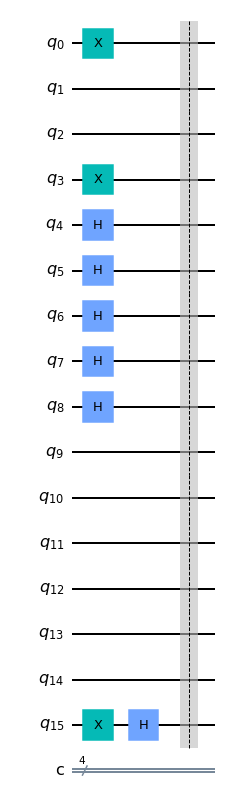

In [113]:
circuit = QuantumCircuit(16,4)

circuit.h([4,5,6,7,8]) 
circuit.x([0,3,15])
circuit.h(15)

circuit.barrier()

circuit.draw('mpl')

### Winning State 1


         X | O | O
     ________________
    
         X | X | X
     ________________
 
         O | O | O   
         
         
1. In winning state 1, <br>
    q<sub>4</sub> = q<sub>5</sub> = |1> <br>
    q<sub>7</sub> = q<sub>8</sub> = |0>
         
To check the solution states, we use 2 Toffoli gates, with the control state set to 0 for one of them, to check the state of the O's.

The outcomes of the 2 Toffoli gates are stored in q<sub>9</sub> and q<sub>10</sub>.

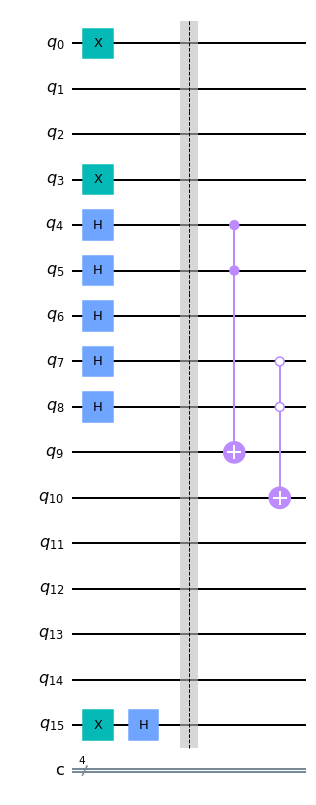

In [114]:
circuit.ccx(4,5,9)
circuit.ccx(7,8,10,ctrl_state=0)
circuit.draw('mpl')

### Winning State 2     


         X | O | O
     ________________

         X | X | O
     ________________

         O | O | X 
         

<vspace>
    
    
    
2. In winning state 2, <br>
    q<sub>4</sub> = q<sub>8</sub> = |1>  <br>
    q<sub>5</sub> = q<sub>7</sub> = |0>
    
Similar to the previous step, using 2 toffoli gates, storing the outcomes in q<sub>11</sub> and q<sub>12</sub> and using control state 0 for O.


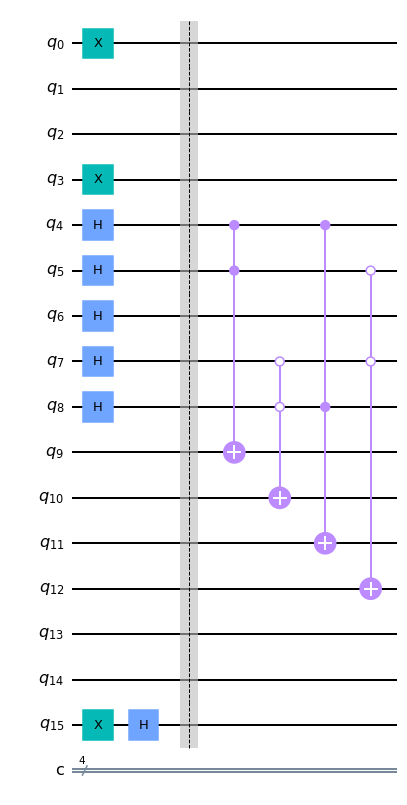

In [115]:
circuit.ccx(4,8,11)
circuit.ccx(5,7,12,ctrl_state=0)
circuit.draw('mpl')

Now, if q<sub>9</sub> and q<sub>10</sub> are both in the |1> state, then winning state 1 is satisfied. So we use another toffoli gate on q<sub>9</sub> and q<sub>10</sub>; and store the outcome in q<sub>13</sub>. If q<sub>13</sub> is |1>, then we have our winning state 1.

Similarly, we check winning state 2 with q<sub>14</sub>, with the control qubits as q<sub>11</sub> and q<sub>12</sub>.

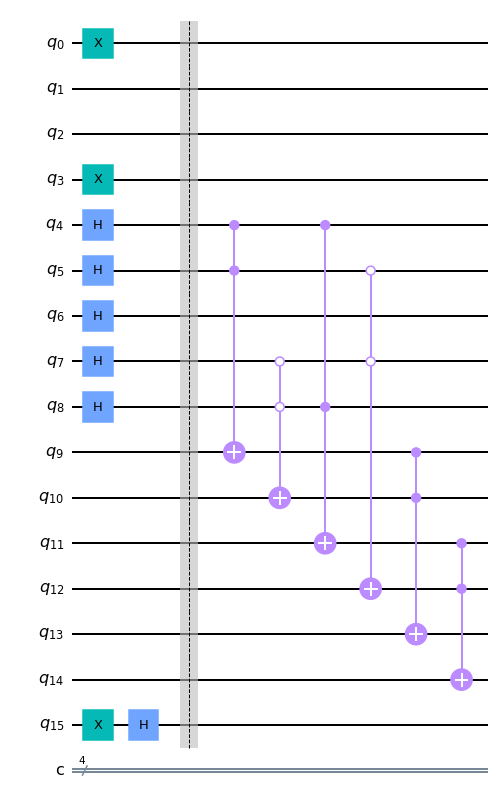

In [116]:
circuit.ccx(9,10,13)
circuit.ccx(11,12,14)
circuit.draw('mpl')

Now, we have to check for exclusivity. Our solution is only valid if one of the winning states are true, else we may get 4 Xs or 4 Os. Thus we perform an XOR operation on q<sub>13</sub> and q<sub>14</sub>, and storing the final outcome in q<sub>15</sub>. 
Thus we have our final check, if q<sub>15</sub> = 1, we have our solution state.

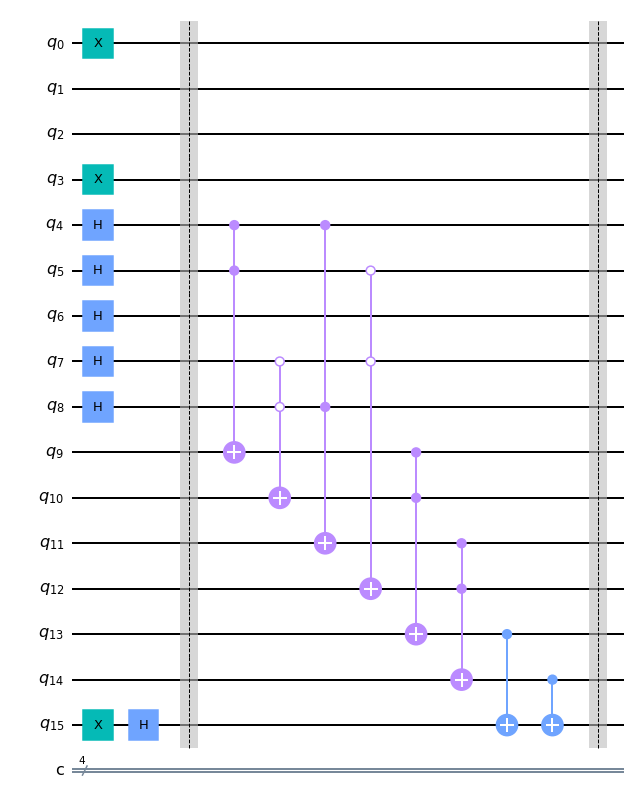

In [117]:
circuit.cx(13,15)
circuit.cx(14,15)

circuit.barrier()

circuit.draw('mpl')

Next, we have our uncomputation process.

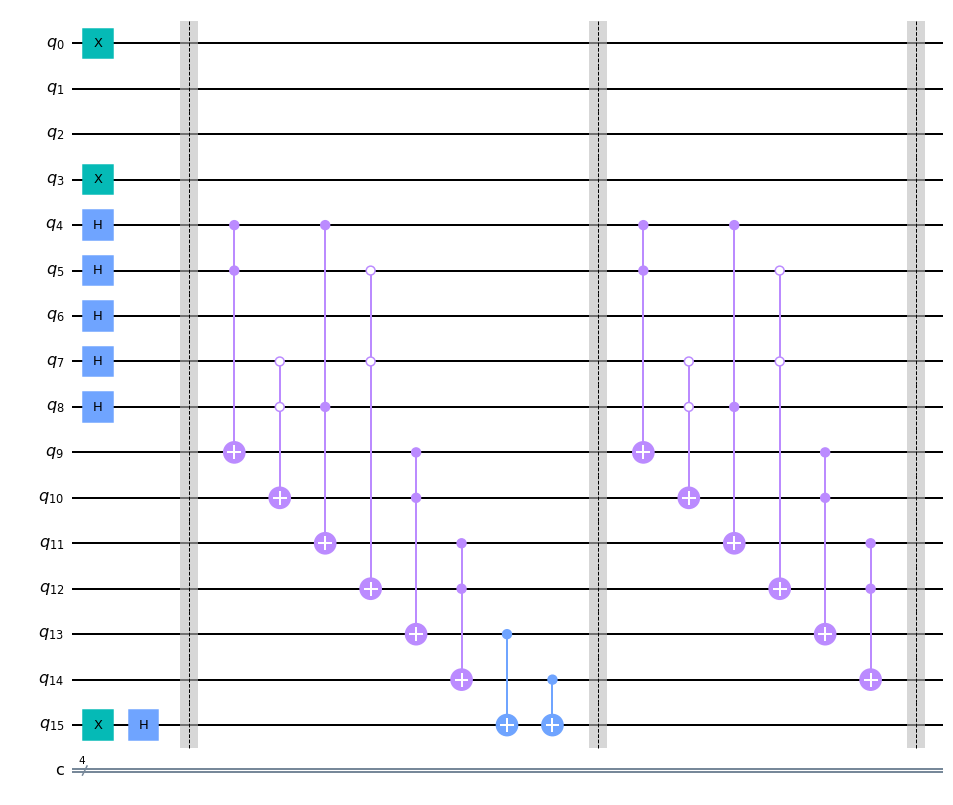

In [118]:
circuit.ccx(4,5,9)
circuit.ccx(7,8,10,ctrl_state=0)

circuit.ccx(4,8,11)
circuit.ccx(5,7,12,ctrl_state=0)

circuit.ccx(9,10,13)
circuit.ccx(11,12,14)

circuit.barrier()

circuit.draw('mpl')

Next we have the Grover diffuser circuit to amplify the probabilties of the solution states. 

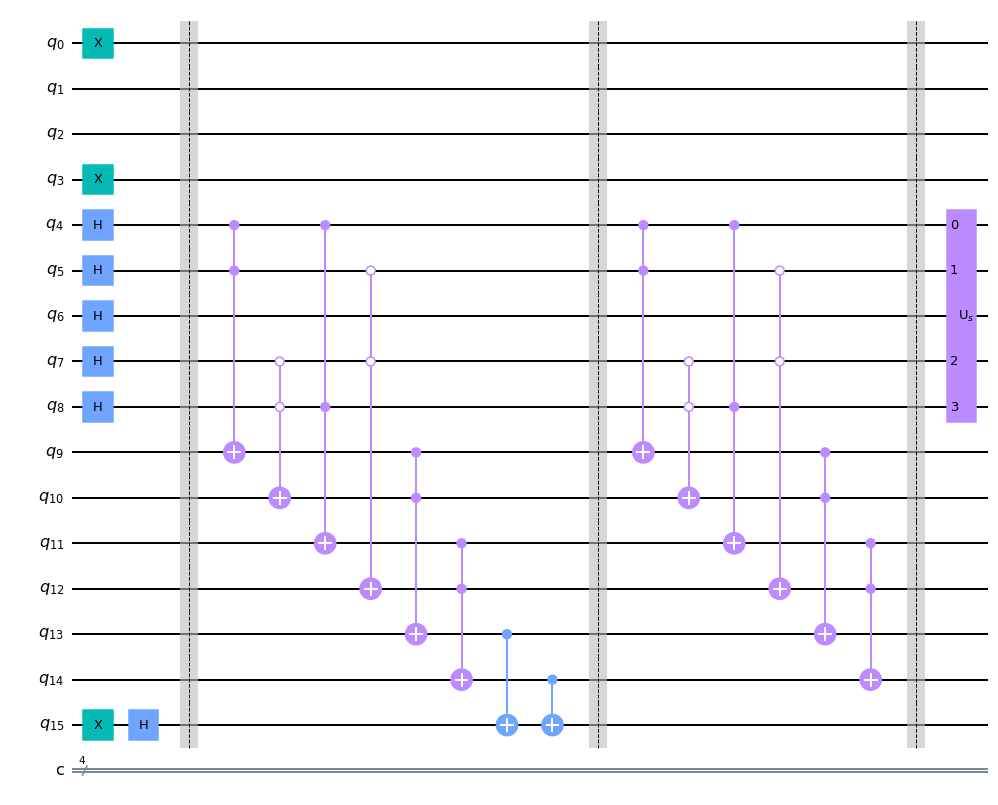

In [119]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # Return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

circuit.append(diffuser(4),[4,5,7,8])
circuit.draw(output = 'mpl')

We finally measure our 4 qubits. 

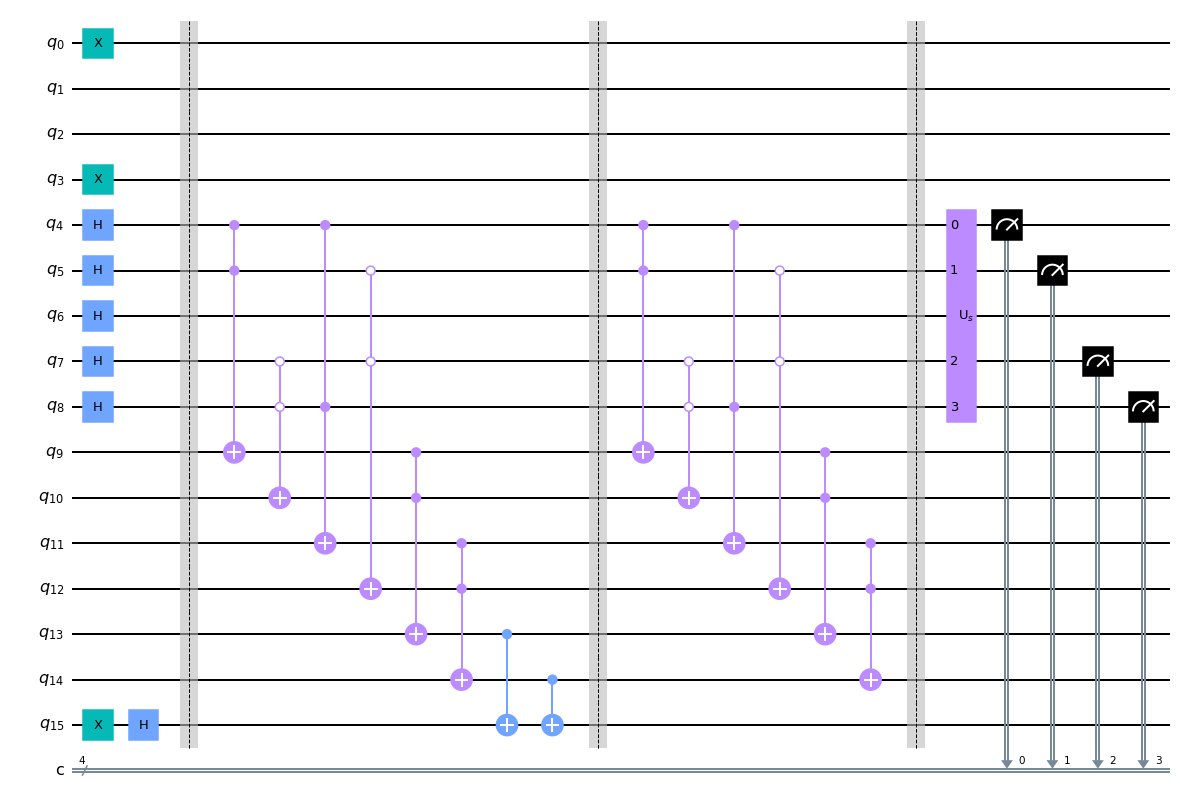

In [120]:
circuit.measure([4,5,7,8],[0,1,2,3])

circuit.draw(output = 'mpl')

Simulating the circuit and getting the histogram 

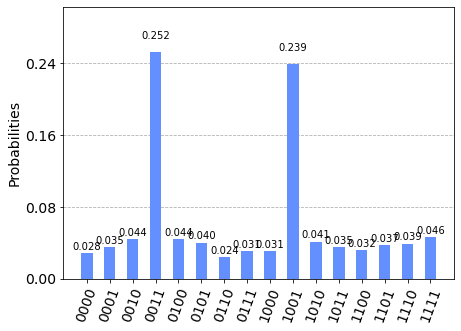

In [121]:
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circuit, backend))
job.result().get_counts(circuit)
plot_histogram(job.result().get_counts(circuit))

Thus we have obtained with high probability, our 2 winning states.

# Bonus

If we start out with this board, 

         X | O | O
     ________________
    
         X |   |  
     ________________
 
           |   |     
         
We have 4 additional states where X wins.

### State 1 

         X | O | O
     ________________
    
         X | X | O
     ________________
 
         X | O | O   

### State 2 

         X | O | O
     ________________
    
         X | O | X
     ________________
 
         X | O | O   
         
### State 3 

         X | O | O
     ________________
    
         X | O | O
     ________________
 
         X | O | X   
         
### State 4 

         X | O | O
     ________________
    
         X | O | O
     ________________
 
         X | X | O   
 
 
These 4 states are in addition to the 2 winning states of the original board.

Now the logic to solve this can be, that is, to integrate these additional winning states to the circuit: 

In all of these new states q<sub>6</sub> is always |1>, and only one of the 4 qubits, i.e, q<sub>4</sub>, q<sub>5</sub>, q<sub>7</sub> and q<sub>8</sub> is |1>.

Hence we can use a 4 qubit-controlled X gate, on
qubits q<sub>4</sub>, q<sub>5</sub>, q<sub>7</sub> and q<sub>8</sub> and use the toffoli gate on the output register with q<sub>6</sub>.

Now on the output register of this toffoli gate, we can use a 3 qubit-controlled X gate, with the other 2 qubits being q<sub>13</sub> and q<sub>14</sub>, to ensure that only one winning state is present.